## Team Name: MovieBuddy
## Team Members: 
## UNI: hs3151 Name: Harguna Sood
## UNI: hj2533 Name: Hritik Jain
## UNI: sk4661 Name: Sachit Kumar
## UNI: sv609  Name: Siddhanth Vinay

## Required packages - pyspark, pandas, seaborn, matplotlib 
## Commented code was for running the code on google colab

## In this notebook, we will build and evaluate ALS models using Spark ML to make recommendations to users.

In [0]:
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [0]:
#!wget -q http://mirrors.viethosting.com/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz

In [0]:
#!tar xf spark-2.4.4-bin-hadoop2.7.tgz

In [0]:
#!pip install -q findspark

In [0]:
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
# import findspark
# findspark.init()
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *

In [0]:
# # Load the Drive helper and mount
# from google.colab import drive

# # This will prompt for authorization.
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd

In [0]:
ratings = spark.read.csv('data/ratings.csv',sep=',', inferSchema = True, header = True)
movies = spark.read.csv('data/movies.csv',sep=',', inferSchema = True, header = True)

In [0]:
#Create a separate row for each genre of a movie.
movies1  = movies.na.drop()
movies1 = movies1.withColumn('genres',explode(split('genres','\|')))

## We first load our ratings sample

In [0]:
sampled_ratings =  spark.read.csv('data/final_sample.csv',sep=',', inferSchema = True, header = True)

In [0]:
sampled_ratings.show(truncate=False)

+------+-------+------+----------+-------------+---+-------------+
|userId|movieId|rating|timestamp |rating_counts|bin|title        |
+------+-------+------+----------+-------------+---+-------------+
|1     |223    |4.0   |1112485573|21371        |5  |Clerks (1994)|
|16    |223    |3.0   |990969977 |21371        |5  |Clerks (1994)|
|21    |223    |3.0   |992190271 |21371        |5  |Clerks (1994)|
|23    |223    |5.0   |914457912 |21371        |5  |Clerks (1994)|
|24    |223    |5.0   |993973215 |21371        |5  |Clerks (1994)|
|25    |223    |4.5   |1277963771|21371        |5  |Clerks (1994)|
|40    |223    |1.0   |940852884 |21371        |5  |Clerks (1994)|
|46    |223    |5.0   |846354925 |21371        |5  |Clerks (1994)|
|48    |223    |3.0   |850710827 |21371        |5  |Clerks (1994)|
|54    |223    |5.0   |974840217 |21371        |5  |Clerks (1994)|
|56    |223    |4.0   |967230562 |21371        |5  |Clerks (1994)|
|58    |223    |4.5   |1144058646|21371        |5  |Clerks (19

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

## Please change the checkpoint directory accordingly so that the code can run for more than 20 iterations.

In [0]:
spark.sparkContext.setCheckpointDir("data/personalization_checkpoint/")

## Running a grid search to find the best values for RegParam and Rank

In [0]:
regParams = [0.002,0.02,0.2,2]
ranks = [5,10,20]

l1= []

for j in regParams:
  for k in ranks:
    als = ALS(maxIter=10, regParam=j, rank = k, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative=True)
    model = als.fit(training)
      # Evaluate the model by computing the R2 on the test data
    predictions = model.transform(test)
    evaluator = RegressionEvaluator(metricName="r2", labelCol="rating",
                                predictionCol="prediction")
    evaluator1 = RegressionEvaluator(metricName="mae", labelCol="rating",
                                predictionCol="prediction")
    r2 = evaluator.evaluate(predictions)
    mae = evaluator1.evaluate(predictions)
    l1.append([j,k,r2,mae])
    print(j,k,r2,mae)      



0.002 5 0.13490590848099548 0.7360127221551083
0.002 10 -0.031973435324738064 0.8012988686348284
0.002 20 -0.1824427769502075 0.8555652793264428
0.02 5 0.14645003577934612 0.7369850517812916
0.02 10 -0.029836895433559052 0.8064259701303281
0.02 20 -0.20138325809607016 0.8753088291878972
0.2 5 0.2833335048682063 0.6914217820812818
0.2 10 0.28732042147648873 0.6897291804873399
0.2 20 0.2826523268820137 0.693399138649072
2 5 -3.357188952851133 2.0064790414353753
2 10 -3.357188972348821 2.0064790465227995
2 20 -3.357188955650095 2.0064790423889303


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

In [0]:
df = pd.DataFrame(l1, columns = ['RegParam' , 'Rank', 'R2','MAE'])
df.head(12)

,RegParam,Rank,R2,MAE
0,0.002,5,0.134906,0.736013
1,0.002,10,-0.031973,0.801299
2,0.002,20,-0.182443,0.855565
3,0.020,5,0.146450,0.736985
4,0.020,10,-0.029837,0.806426
5,0.020,20,-0.201383,0.875309
6,0.200,5,0.283334,0.691422
7,0.200,10,0.287320,0.689729
8,0.200,20,0.282652,0.693399
9,2.000,5,-3.357189,2.006479


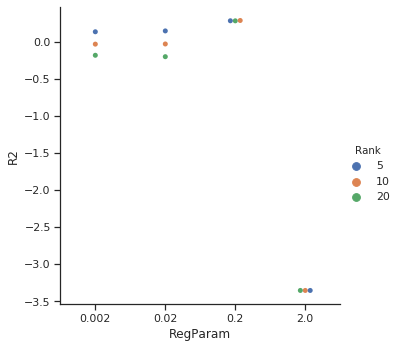

In [0]:
sns.catplot(x="RegParam", y="R2", hue="Rank", kind="swarm", data=df)

### From the data and the plots, we can see that RegParam = 0.2 and Rank = 10 gave us the best results

## Since doing gridsearch on all combinations was unfeasible, we did a first gridsearch to find the best RegParam and Rank combination and will now find the best MaxIter value for that RegParam, Rank combination.

In [0]:
iterations = [5,10,20,50]
iter_search = []
for k in iterations:
    als = ALS(maxIter=k, regParam=0.2, rank = 10, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative=True)
    model = als.fit(training)
      # Evaluate the model by computing the R2 on the test data
    predictions = model.transform(test)
    evaluator = RegressionEvaluator(metricName="r2", labelCol="rating",
                                predictionCol="prediction")
    evaluator1 = RegressionEvaluator(metricName="mae", labelCol="rating",
                                predictionCol="prediction")
    r2 = evaluator.evaluate(predictions)
    mae = evaluator1.evaluate(predictions)
    iter_search.append([k,r2,mae])
    print(k,r2,mae)      

5 0.29182074110021994 0.6834456567454458
10 0.28732042147648873 0.6897291804873399
20 0.281275477699494 0.6947792616749608
50 0.28066562461616984 0.6953180141492316


In [0]:
df_iter = pd.DataFrame(iter_search, columns = ['Iterations', 'R2','MAE'])
df_iter.head()

,Iterations,R2,MAE
0,5,0.291821,0.683446
1,10,0.287320,0.689729
2,20,0.281275,0.694779
3,50,0.280666,0.695318


### The best results were given when ALS ran for 5 iterations. 

## We assume that this is the best combination of hyperparameters and that the best combination will not change when we do k-fold cross validation (due to unfeasibility of running k-fold for each grid search parameter). 

In [0]:
sub_1, sub_2, sub_3, sub_4, sub_5 = sampled_ratings.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2])

In [0]:
eval_list = []
for i in range(5):
  if i == 0:
    training = sub_2.union(sub_3).union(sub_4).union(sub_5)
    test = sub_1
  elif i == 1:
    training = sub_1.union(sub_3).union(sub_4).union(sub_5)
    test = sub_2
  elif i == 2:
    training = sub_1.union(sub_2).union(sub_4).union(sub_5)
    test = sub_3
  elif i == 3:
    training = sub_1.union(sub_2).union(sub_3).union(sub_5)
    test = sub_4
  elif i == 4:
    training = sub_1.union(sub_2).union(sub_3).union(sub_4)
    test = sub_5
  als = ALS(maxIter=5, regParam=0.2, rank = 10, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative=True)
  model = als.fit(training)
      # Evaluate the model by computing the R2 on the test data
  predictions = model.transform(test)
  evaluator = RegressionEvaluator(metricName="r2", labelCol="rating",
                                predictionCol="prediction")
  evaluator1 = RegressionEvaluator(metricName="mae", labelCol="rating",
                                predictionCol="prediction") 
  r2 = evaluator.evaluate(predictions)
  mae = evaluator1.evaluate(predictions)
  print(i+1,r2,mae)
  eval_list.append([r2,mae])

1 0.28800371379512646 0.6855673575834418
2 0.2858201807665737 0.6858847555514855
3 0.2850479799918514 0.6891123107990713
4 0.2848507208581412 0.6882594708401278
5 0.28685958656621535 0.6864943375699118


In [0]:
df_eval = pd.DataFrame(eval_list, columns = ['R2','MAE'])
df_eval.head()

,R2,MAE
0,0.288004,0.685567
1,0.285820,0.685885
2,0.285048,0.689112
3,0.284851,0.688259
4,0.286860,0.686494


In [0]:
mean_r2 = df_eval['R2'].mean()
mean_mae = df_eval['MAE'].mean()
print(mean_r2,mean_mae)

0.2861164363955816 0.6870636464688076


## We now consider the top 10 recommendations and try to compute the Catalog Coverage


In [0]:
(training, test) = sampled_ratings.randomSplit([0.8, 0.2]) 
als = ALS(maxIter=5, regParam=0.2, rank = 10, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative=True)
model = als.fit(training)

In [0]:
recommendations = model.recommendForAllUsers(10)

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

def recommended_movies(recommendations):
    movie_ids = [str(i[0]) for i in recommendations]
    return ','.join(movie_ids)

recommended_movies_udf = udf(recommended_movies, StringType())

In [0]:
recommendations1 = recommendations.withColumn('movies',recommended_movies_udf(recommendations['recommendations']))

In [0]:
#Convert the recommendations list to a userId, movieId combination
recommendations2 = recommendations1.select('userId','movies')
recommendations2 = recommendations2.withColumn('movieId',explode(split('movies',',')))

In [0]:
#Get the list of unique movies in the recommendation
unique_movies = recommendations2.select('movieId').dropDuplicates()

In [0]:
pd_movies = unique_movies.toPandas()

In [0]:
#Since our sample has 1000 movies, compute coverage as percentage of the 1000 movies that have been recommended
print("Coverage = ", (len(pd_movies)/1000)*100,"%")

Coverage =  16.8 %


### Since our recommendations contains some movies that have already been watched by the user, we remove those movies and then recompute the catalog coverage.

In [0]:
users_movies = training.select('userId','movieId').dropDuplicates()

In [0]:
recommendations2 = recommendations2.dropDuplicates()

In [0]:
recommendations3 = recommendations2.select('userId','movieId')
recommendations4 = recommendations3.subtract(users_movies)

In [0]:
unique_movies_2 = recommendations4.select('movieId').dropDuplicates()

In [0]:
pd_movies_2 = unique_movies_2.toPandas()

In [0]:
print("Coverage of unseen movies = ", (len(pd_movies_2)/1000)*100,"%")

Coverage of unseen movies =  16.1 %


### Catalog Coverage is 16.8% when including movies the user has already watched and it reduces to 16.1% when we recommend only new movies to users.

## We now want to see the distribution of the number of ratings for these 161 newly recommended movies (we sampled ratings for 1000 movies).

In [0]:
pd_movies_2['movieId'] = pd.to_numeric(pd_movies_2['movieId'])

In [0]:
sampled_pd = sampled_ratings.toPandas()
movie_counts = sampled_pd.groupby('movieId').size().reset_index(name='counts')
movie_counts.head()

,movieId,counts
0,5,10950
1,19,18877
2,21,21690
3,41,4223
4,45,8025


In [0]:
recommended_movie_counts = movie_counts.merge(pd_movies_2,on ='movieId')

In [0]:
recommended_movie_counts['counts'].describe()

count      161.000000
mean      3985.534161
std       8431.191864
min          1.000000
25%          6.000000
50%         50.000000
75%       3306.000000
max      47120.000000
Name: counts, dtype: float64

### Looking at the data distribution, we see that movies in all ranges of movie counts are being predicted by the model (25% of the recommended movies has between 1 and 6 ratings, 25% between 6 and 50 ratings, 25% between 50 and 3306 ratings and 25% of the recommended movies have above 3306 ratings. Thus, the model is able to recommend movies with low and high number of ratings, which is what we hoped to build.

## We want to see how our model increases with increasing the sample size (we will consider a sample of 1500 movie, a sample of 2000 movies, a sample of 5000 movies and measure r2 and mae for these sample sizes)

In [0]:
sampled_ratings_2 =  spark.read.csv('data/final_sample_2.csv',sep=',', inferSchema = True, header = True)
(training_2, test_2) = sampled_ratings_2.randomSplit([0.8, 0.2])

als_2 = ALS(maxIter=5, regParam=0.2, rank = 10, userCol="userId", itemCol="movieId", ratingCol="rating",coldStartStrategy="drop", nonnegative=True)
model_2 = als_2.fit(training_2)

# Evaluate the model by computing the R2 on the test data
predictions_2 = model_2.transform(test_2)
evaluator_2 = RegressionEvaluator(metricName="r2", labelCol="rating",
                                predictionCol="prediction")
evaluator_3 = RegressionEvaluator(metricName="mae", labelCol="rating",
                                predictionCol="prediction")

r2_2 = evaluator_2.evaluate(predictions_2)
mae_2 =  evaluator_3.evaluate(predictions_2)

print("R2 = " + str(r2_2))
print("MAE = " + str(mae_2))

R2 = 0.29702558855314676
MAE = 0.6772190784536676


In [0]:
sampled_ratings_3 =  spark.read.csv('data/final_sample_3.csv',sep=',', inferSchema = True, header = True)
(training_3, test_3) = sampled_ratings_3.randomSplit([0.8, 0.2])

als_3 = ALS(maxIter=5, regParam=0.2, rank = 10, userCol="userId", itemCol="movieId", ratingCol="rating",coldStartStrategy="drop", nonnegative=True)
model_3 = als_3.fit(training_3)

# Evaluate the model by computing the R2 on the test data
predictions_3 = model_2.transform(test_3)
evaluator_4 = RegressionEvaluator(metricName="r2", labelCol="rating",
                                predictionCol="prediction")
evaluator_5 = RegressionEvaluator(metricName="mae", labelCol="rating",
                                predictionCol="prediction")

r2_3 = evaluator_4.evaluate(predictions_3)
mae_3 =  evaluator_5.evaluate(predictions_3)

print("R2 = " + str(r2_3))
print("MAE = " + str(mae_3))

R2 = 0.38234772970048203
MAE = 0.6367361311418589


In [0]:
sampled_ratings_4 =  spark.read.csv('data/final_sample_4.csv',sep=',', inferSchema = True, header = True)
(training_4, test_4) = sampled_ratings_4.randomSplit([0.8, 0.2])

als_4 = ALS(maxIter=5, regParam=0.2, rank = 10, userCol="userId", itemCol="movieId", ratingCol="rating",coldStartStrategy="drop", nonnegative=True)
model_4 = als_4.fit(training_4)

# Evaluate the model by computing the R2 on the test data
predictions_4 = model_4.transform(test_4)
evaluator_6 = RegressionEvaluator(metricName="r2", labelCol="rating",
                                predictionCol="prediction")
evaluator_7 = RegressionEvaluator(metricName="mae", labelCol="rating",
                                predictionCol="prediction")

r2_4 = evaluator_6.evaluate(predictions_4)
mae_4 =  evaluator_7.evaluate(predictions_4)

print("R2 = " + str(r2_4))
print("MAE = " + str(mae_4))

R2 = 0.3230222399361311
MAE = 0.6664716692287066


### Increasing the sample size does improve the goodness of fit and mean absolute error when the sample size is increased from 1000 to 2000 and 2500 movies, although the metrics do become poorer (still better than the samples of size 1000 and 2000) when the sample size is made much larger (5000 movies).

### We also noticed that increasing the sample size did not increase the run time by too much, with the original 1000 movies sample taking 4 minutes to run while the 5000 movies sample took around 7 minutes to run.

## From the original sample of ratings for 1000 movies, we will add a business rule where for each user, we will take the top 2 genre counts of all the movies they have rated 3.5 and above and randomly recommend 3 movies (which have lesser than 500 ratings and have an average rating of 3+) from those 2 genres. Thus, we want to improve our discovery and coverage by recommending movies that have high average ratings but low number of ratings to users. This not only exposes those movies but will also hopefully be watched by more users now, thus giving us a better training set in the future where these movies have high number of ratings.

In [0]:
sampled_pd = sampled_ratings.toPandas()

In [0]:
#Get only those ratings for each user which have a rating above 3.5
sampled_pd_subset = sampled_pd[sampled_pd.rating >= 3.5]

In [0]:
#Get the dataframe containing all movies to genres combinations
movies1_pd = movies1.drop('title').toPandas()

In [0]:
#Merge these genres back to the users
merged_sample = sampled_pd_subset.merge(movies1_pd,on="movieId")

In [0]:
merged_sample.head()

,userId,movieId,rating,timestamp,rating_counts,bin,title,genres
0,1,223,4.0,1112485573,21371,5,Clerks (1994),Comedy
1,23,223,5.0,914457912,21371,5,Clerks (1994),Comedy
2,24,223,5.0,993973215,21371,5,Clerks (1994),Comedy
3,25,223,4.5,1277963771,21371,5,Clerks (1994),Comedy
4,46,223,5.0,846354925,21371,5,Clerks (1994),Comedy


In [0]:
#Get a count of the number of times each user watched a movie of a particular genre.
users_genres = merged_sample.loc[:,['userId','genres']]
users_genres = users_genres.groupby(['userId','genres']).size().reset_index(name='count')
users_genres.head()

,userId,genres,count
0,1,Action,11
1,1,Adventure,11
2,1,Animation,1
3,1,Children,1
4,1,Comedy,6


In [0]:
users_genres['count'] = pd.to_numeric(users_genres['count'])

In [0]:
#Sort the genre counts for each user in descending order
users_genres_sort = users_genres.sort_values(by=['userId','count'],ascending=[True,False])
users_genres_sort.head()

,userId,genres,count
0,1,Action,11
1,1,Adventure,11
7,1,Fantasy,10
4,1,Comedy,6
6,1,Drama,6


In [0]:
#Pick top 2 genres watched by each user
users_genres_sub = users_genres_sort.groupby(['userId']).head(2).reset_index(drop=True)
users_genres_sub_1 = users_genres_sub.drop(['count'],axis = 1)
users_genres_sub_1.head()

,userId,genres
0,1,Action
1,1,Adventure
2,2,Action
3,2,Drama
4,3,Action


In [0]:
#Select only movies which have lower than 500 ratings and have a rating above 3
movies_groups = sampled_pd.groupby('movieId')['rating'].agg(['count','mean'])
movies_subset = movies_groups[movies_groups['count'] <= 500]
movies_subset = movies_subset[movies_subset['mean']>=3]
movies_subset.head()

,count,mean
movieId,,
59,170,3.535294
124,294,3.527211
394,118,3.330508
659,382,3.678010
746,281,3.779359


In [0]:
#Map these movies to their genres
movies_subset_1 = movies_subset.merge(movies1_pd,on='movieId')
movies_subset_2 = movies_subset_1.loc[:,['movieId','genres']]
movies_subset_2.head()

,movieId,genres
0,59,Drama
1,59,Mystery
2,124,Drama
3,394,Comedy
4,659,Crime


In [0]:
#Merge with the users to get all movies for the top 2 genres watched by a user.
merged = movies_subset_2.merge(users_genres_sub_1,on="genres")
merged.head()

,movieId,genres,userId
0,59,Drama,2
1,59,Drama,5
2,59,Drama,6
3,59,Drama,7
4,59,Drama,8


In [0]:
#Shuffle the data and select 3 movies to recommend to every user
merged = merged.sample(frac=1)
business_rec = merged.groupby(['userId']).head(3).reset_index(drop=True)
business_rec = business_rec.loc[:,['userId','movieId']]
business_rec.head()

,userId,movieId
0,31119,104451
1,84421,91531
2,90933,40959
3,53230,5124
4,61606,115174


In [0]:
business_rec_spark = spark.createDataFrame(business_rec)
business_rec_spark.show(truncate=False)

+------+-------+
|userId|movieId|
+------+-------+
|31119 |104451 |
|84421 |91531  |
|90933 |40959  |
|53230 |5124   |
|61606 |115174 |
|130141|78585  |
|122564|4670   |
|40547 |78583  |
|22068 |56570  |
|107351|103840 |
|76288 |54771  |
|83656 |79213  |
|3573  |115877 |
|17590 |26236  |
|26443 |115210 |
|100582|108979 |
|22549 |65562  |
|71163 |32797  |
|24018 |4076   |
|13088 |94503  |
+------+-------+
only showing top 20 rows



## We will now compute the modified catalog coverage to see if our business objective of improving catalog coverage has been achieved.

In [0]:
recommendations_sub = recommendations2.select('userId','movieId')
total_recommendations = recommendations_sub.union(business_rec_spark)
total_recommendations = total_recommendations.dropDuplicates()

In [0]:
total_recommendations1 = total_recommendations.subtract(users_movies)
unique_movies_3 = total_recommendations1.select('movieId').dropDuplicates()
pd_movies_3 = unique_movies_3.toPandas()
print("Coverage of unseen movies = ", (len(pd_movies_3)/1000)*100,"%")

Coverage of unseen movies =  46.1 %


### We see that our coverage on newly recommended movies increases drastically from 16.1% to 46.1% when we add our business rule.

## Finally, we will evaluate our model on an unseen 10% test data.

In [0]:
final_test_ratings =  spark.read.csv('data/ratings_test.csv',sep=',', inferSchema = True, header = True)

In [0]:
# Evaluate the model by computing the R2 on the test data
predictions_fin = model.transform(final_test_ratings)
evaluator_fin = RegressionEvaluator(metricName="r2", labelCol="rating",
                                predictionCol="prediction")
evaluator_fin_mae = RegressionEvaluator(metricName="mae", labelCol="rating",
                                predictionCol="prediction")

r2_fin = evaluator_fin.evaluate(predictions_fin)
mae_fin =  evaluator_fin_mae.evaluate(predictions_fin)

print("R2 = " + str(r2_fin))
print("MAE = " + str(mae_fin))

R2 = 0.2885387217708627
MAE = 0.6850313912908458


### The R2 = 0.28 and MAE = 0.685 is consistent with the rest of our observations.